In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

try:
    import setGPU
except:
    print('no setGPU')

I0808 21:09:02.358021 4784422336 file_utils.py:39] PyTorch version 1.1.0.post2 available.
I0808 21:09:02.358921 4784422336 file_utils.py:55] TensorFlow version 2.2.0 available.
I0808 21:09:02.804661 4784422336 _import_c_extension.py:31] Failed to import cuda module: No module named 'caffe2.python.caffe2_pybind11_state_gpu'
I0808 21:09:02.805714 4784422336 _import_c_extension.py:38] Failed to import AMD hip module: No module named 'caffe2.python.caffe2_pybind11_state_hip'
W0808 21:09:02.806438 4784422336 _import_c_extension.py:41] This caffe2 python run does not have GPU support. Will run in CPU only mode.


no setGPU


In [2]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [15]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased",
#                                           cache_dir='bert_ckpt',
#                                           do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased",
                                          cache_dir='bert_ckpt',
                                          do_lower_case=False)

I0808 21:10:50.383285 4784422336 filelock.py:274] Lock 140383558033024 acquired on bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729.lock
I0808 21:10:50.384625 4784422336 file_utils.py:437] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache or force_download set to True, downloading to /Users/chojunghyun/project/personal/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/bert_ckpt/tmpgi712vgd


I0808 21:10:53.000746 4784422336 file_utils.py:441] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt in cache at bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
I0808 21:10:53.001456 4784422336 file_utils.py:444] creating metadata file for bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
I0808 21:10:53.003083 4784422336 filelock.py:318] Lock 140383558033024 released on bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729.lock
I0808 21:10:53.003705 4784422336 tokenization_utils.py:1022] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080b

In [16]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 53 * 2 # Average total * 2

DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [17]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[PAD]', '[CLS]', '[UNK]', '[MASK]', '[SEP]'] 
 [0, 101, 100, 103, 102]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


# KorSTS Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [18]:
# Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter = '\t', quoting = 3)

train_data = train_data.dropna()

dev_data = dev_data.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 5749, dev - 1500


In [19]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [20]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
    return sent_clean

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

# DEV SET Preprocessing

In [21]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

In [22]:
print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 5749, #dev labels: 1500


In [23]:
class TFBertRegressor(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.num_labels = 1
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_labels, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(config.initializer_range), 
                                                name="regressor")
        
    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        logits = self.regressor(pooled_output)

        return tf.reshape(logits, (-1))

In [33]:
bert_config = BertConfig()
regression_model = TFBertRegressor(bert_config).from_pretrained("bert-base-multilingual-cased",
                                                                 cache_dir='bert_ckpt')

I0808 21:26:45.061994 4784422336 filelock.py:274] Lock 140383308897360 acquired on bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0.lock
I0808 21:26:45.063571 4784422336 file_utils.py:437] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json not found in cache or force_download set to True, downloading to /Users/chojunghyun/project/personal/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/bert_ckpt/tmp0g3sfsrg


I0808 21:26:46.182074 4784422336 file_utils.py:441] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json in cache at bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
I0808 21:26:46.183269 4784422336 file_utils.py:444] creating metadata file for bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
I0808 21:26:46.184336 4784422336 filelock.py:318] Lock 140383308897360 released on bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0.lock
I0808 21:26:46.185003 4784422336 configuration_utils.py:265] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f98

I0808 21:28:23.087100 4784422336 file_utils.py:441] storing https://cdn.huggingface.co/bert-base-multilingual-cased-tf_model.h5 in cache at bert_ckpt/273ed844d60ef1d5a4ea8f7857e3c3869d05d7b22296f4ae9bc56026ed40eeb7.1b4841f14bf42137fc7ecee17a46c1b2f22b417f636347e4b810bd06dd9c45ea.h5
I0808 21:28:23.087785 4784422336 file_utils.py:444] creating metadata file for bert_ckpt/273ed844d60ef1d5a4ea8f7857e3c3869d05d7b22296f4ae9bc56026ed40eeb7.1b4841f14bf42137fc7ecee17a46c1b2f22b417f636347e4b810bd06dd9c45ea.h5
I0808 21:28:23.088940 4784422336 filelock.py:318] Lock 140383567258960 released on bert_ckpt/273ed844d60ef1d5a4ea8f7857e3c3869d05d7b22296f4ae9bc56026ed40eeb7.1b4841f14bf42137fc7ecee17a46c1b2f22b417f636347e4b810bd06dd9c45ea.h5.lock
I0808 21:28:23.089594 4784422336 modeling_tf_utils.py:384] loading weights file https://cdn.huggingface.co/bert-base-multilingual-cased-tf_model.h5 from cache at bert_ckpt/273ed844d60ef1d5a4ea8f7857e3c3869d05d7b22296f4ae9bc56026ed40eeb7.1b4841f14bf42137fc7ecee17a4

I0808 21:28:24.962910 4784422336 modeling_tf_utils.py:422] Layers of TFBertRegressor not initialized from pretrained model: ['classifier', 'dropout_189']
I0808 21:28:24.963521 4784422336 modeling_tf_utils.py:426] Layers from pretrained model not used in TFBertRegressor: ['mlm___cls', 'nsp___cls']


In [34]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)
        
        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []
        

    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return num / den

In [35]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [36]:
#학습 진행하기
model_name = "tf2_BERT_KorSTS"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = regression_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

data_out/KOR/tf2_BERT_KorSTS -- Folder already exists 

Epoch 1/3
 14/180 [=>............................] - ETA: 47:59 - loss: 3.3497 - pearson_correlation: -0.0188

KeyboardInterrupt: 

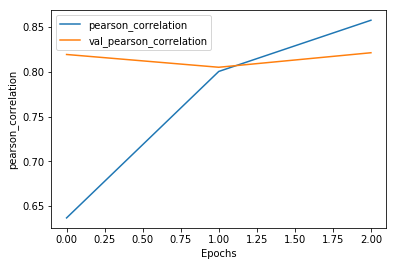

In [18]:
plot_graphs(history, 'pearson_correlation')

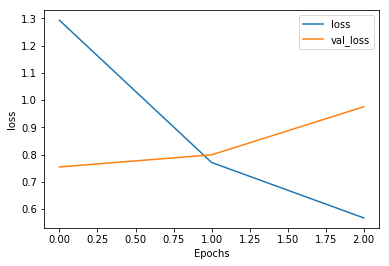

In [19]:
plot_graphs(history, 'loss')

# KorSTS Test dataset

In [14]:
# Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-test.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.


In [15]:
# Test set도 똑같은 방법으로 구성한다.
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

In [16]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 1379, # labels: 1379


In [169]:
results = regression_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

3/3 [==============================] - 35s 12s/step - loss: 1.1421 - PearsonCorrelation: 0.7348
test loss, test pearson correlation:  [1.1420584917068481, 0.7348241209983826]
